## LSTMs

## Demo 1 - torch.nn.LSTM

No PytTorch, a classe [torch.nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) provê a implementação de uma célula LSTM. Essa classe implementa as seguintes equações:

![texto do link](https://i.imgur.com/A9reTrh.png)

Da documentação do PyTorch:

- `input_size` – The number of expected features in the input x
- `hidden_size` – The number of features in the hidden state h
- `num_layers` – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1

Como exemplo, considere uma arquitetura LSTM em que foram definidos:
- $c_𝑡 \in \mathbb{R}^2$
- $ℎ_𝑡 \in \mathbb{R}^2$
- $𝑥_𝑡 \in \mathbb{R}^3$

![texto do link](https://i.imgur.com/Ifn6yVs.png)

Cada camada sigmoid, tanh ou de estado oculto em uma célula LSTM é na verdade uma rede neural feed forward de uma única camada oculta, cujo número de neurônios é definido pelo parâmetro `hidden_size`. 

- Se definirmos `hidden_size = 2`, cada célula LSTM terá redes neurais com 2 neurônios em sua camada oculta.

- Se definirmos `input_size = 3`, cada elemento da sequência de entrada será representado por um vetor de três dimensões.

In [22]:
import torch.nn as nn
hidden_size = 2
input_size = 3
lstm1 = nn.LSTM(input_size, hidden_size, num_layers=1)

Uma célula LSTM possui as seguintes propriedades (texto a seguir também retirado da [documentação do PyTorch](https://pytorch.org/docs/stable/nn.html)):

- weight_ih_l[k] – the learnable input-hidden weights of the $\text{k}^{th}$ ($W_{ii}|W_{if}|W_{ig}|W_{io}$), of shape (4$\times$hidden_size, input_size) for $k = 0$.

- weight_hh_l[k] – the learnable hidden-hidden weights of the $\text{k}^{th}k$ layer ($W_{hi}|W_{hf}|W_{hg}|W_{ho}$), of shape (4*hidden_size, hidden_size)


Para a célula LSTM apresentada nesta seção, valem as seguintes dimensões:

$$
W_{ii}, W_{if}, W_{ig}, W_{io} \in \mathbb{R}^{2 \times 3}
$$

In [23]:
print(lstm1.weight_ih_l0.size())
print(lstm1.weight_ih_l0)

torch.Size([8, 3])
Parameter containing:
tensor([[ 0.4121,  0.6533,  0.5232],
        [ 0.4260,  0.4085, -0.1483],
        [ 0.6538, -0.4274, -0.2896],
        [-0.2773,  0.6607,  0.1427],
        [ 0.2640, -0.4946,  0.4539],
        [-0.3792, -0.1609, -0.2995],
        [ 0.3245, -0.2697,  0.0729],
        [-0.2525, -0.6429,  0.1652]], requires_grad=True)


Para a célula LSTM apresentada nesta seção, valem as seguintes dimensões:

$$
W_{hi}, W_{hf}, W_{hg}, W_{ho} \in \mathbb{R}^{2 \times 2}
$$

In [24]:
print(lstm1.weight_hh_l0.size())
print(lstm1.weight_hh_l0)

torch.Size([8, 2])
Parameter containing:
tensor([[ 0.4914,  0.0930],
        [-0.0620,  0.6100],
        [ 0.0506, -0.4856],
        [-0.0948,  0.2273],
        [-0.0662, -0.2632],
        [-0.3716, -0.0845],
        [ 0.6347,  0.2927],
        [-0.1908, -0.6159]], requires_grad=True)


## Demo 2 - Previsão de séries multivariadas

**Créditos**: o exemplo desta seção foi adaptado do encontrado em [Multivariate input LSTM in pytorch](https://stackoverflow.com/questions/56858924/multivariate-input-lstm-in-pytorch).

Esta seção apresenta um exemplo muito simples de treinamento de um modelo de rede LSTM para predição no contexto de uma série temporal multivariada.

> Considere uma série temporal multivariada na qual há três observações (variáveis medidas) por passo de tempo. Dessas três variáveis, uma dela é alvo (i.e., a que desejamos predizer). As outras duas serão usadas como variáveis independentes. Considere também a tarefa de ajustar um modelo de predição no qual são usadas observações de três passos de tempo no passado para predizer o valor da variável de interesse no passo de tempo atual.

### Preparação dos dados

Vamos de início gerar um conjunto de dados sintético. Esse conjunto de dados simula uma série temporal multivariada na qual, a cada passo de tempo são observadas (medidas) três variáveis.

Concretamente, esse código:
- Gera uma série multivariada com 2 entradas e 1 saída.
- Empacota essas sequências em janelas deslizantes para alimentar modelos temporais como LSTMs.



In [25]:
import random
import numpy as np
import torch

# multivariate data preparation
from numpy import array
from numpy import hstack
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
 
# define input sequence
in_seq1 = array([x for x in range(0,100,10)])
in_seq2 = array([x for x in range(5,105,10)])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))

A série temporal multivariada gerada pelo código acima é apresentada a seguir. Repare que há 10 passos de tempo, em cada um dos quais, três observações são realizadas.

In [26]:
dataset

array([[  0,   5,   5],
       [ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185]])

# Visualização da séries

A imagem (plot) a seguir) mostra as três séries temporais:

* **in\_seq1** (bolinhas): sequência crescente começando de 0.
* **in\_seq2** (quadrados): sequência semelhante, mas iniciando em 5.
* **out\_seq** (triângulos tracejados): é a soma elemento a elemento de `in_seq1` e `in_seq2`.

As **setas cinza** indicam como os valores de `in_seq1` e `in_seq2` contribuem para formar `out_seq` em cada passo de tempo.

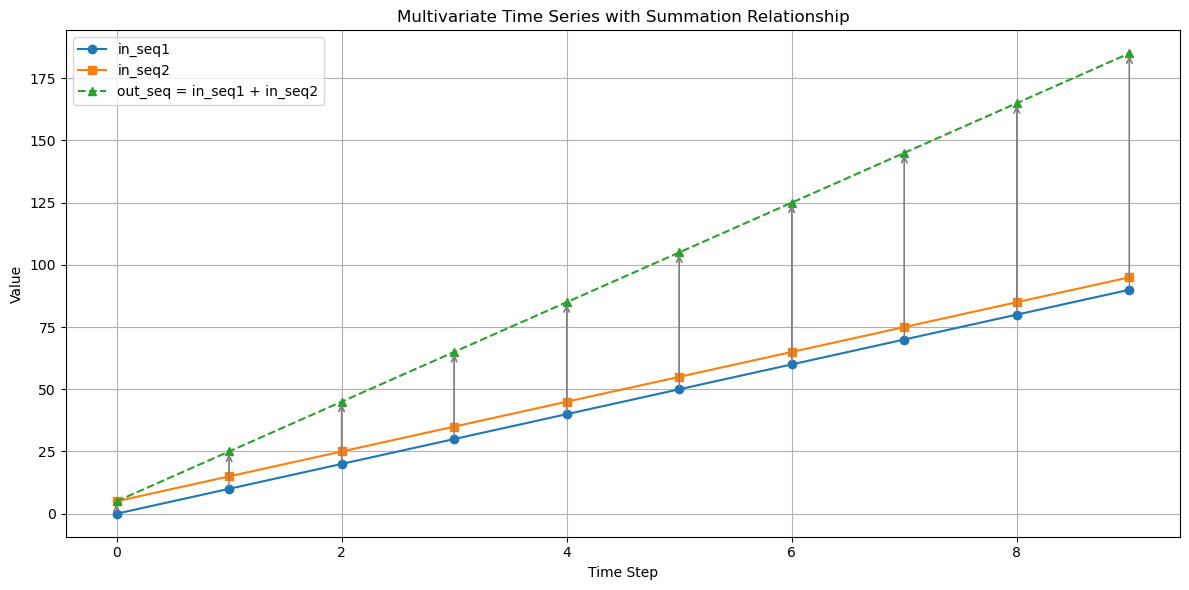

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Dados
in_seq1 = np.array([x for x in range(0, 100, 10)])
in_seq2 = np.array([x for x in range(5, 105, 10)])
out_seq = np.array([in_seq1[i] + in_seq2[i] for i in range(len(in_seq1))])
t = np.arange(len(in_seq1))  # eixo do tempo

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(t, in_seq1, marker='o', label='in_seq1')
ax.plot(t, in_seq2, marker='s', label='in_seq2')
ax.plot(t, out_seq, marker='^', label='out_seq = in_seq1 + in_seq2', linestyle='--')

# Anotações com setas
for i in range(len(t)):
    ax.annotate('', xy=(t[i], out_seq[i]), xytext=(t[i], in_seq1[i]),
                arrowprops=dict(arrowstyle='->', color='gray'))
    ax.annotate('', xy=(t[i], out_seq[i]), xytext=(t[i], in_seq2[i]),
                arrowprops=dict(arrowstyle='->', color='gray'))

# Destaques visuais
ax.set_title('Multivariate Time Series with Summation Relationship')
ax.set_xlabel('Time Step')
ax.set_ylabel('Value')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


O parâmetro `n_timesteps` representa o número de passos de tempo anteriores que o modelo irá considerar como **entrada (X)** para prever a **saída (y)** no último passo da janela.


In [28]:
n_timesteps = 3 # this is number of timesteps

A imagem abaixo mostra a **série multivariada** com uma **janela deslizante de tamanho $n\_steps = 3$** destacada em **amarelo translúcido**.

Janela destacada:

* Corresponde aos passos de tempo `t = 4`, `5` e `6`.
* Esses três pontos são usados como **entrada do modelo** (X).

Linha vertical pontilhada:

* Indica o ponto `t = 6`, que é o último passo da janela.
* O valor da série `out_seq` nesse ponto é considerado a **saída alvo (y)** associada à janela.

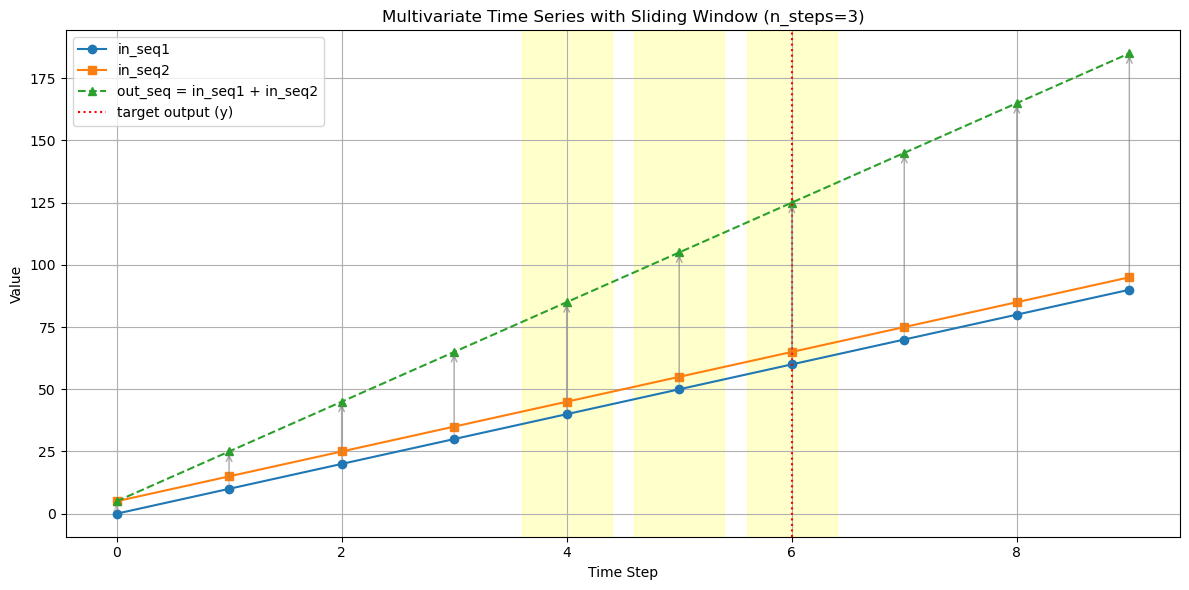

In [29]:
# Número de passos na janela
highlight_index = 4  # início da janela a ser destacada

fig, ax = plt.subplots(figsize=(12, 6))

# Plot das séries
ax.plot(t, in_seq1, marker='o', label='in_seq1')
ax.plot(t, in_seq2, marker='s', label='in_seq2')
ax.plot(t, out_seq, marker='^', label='out_seq = in_seq1 + in_seq2', linestyle='--')

# Anotações com setas
for i in range(len(t)):
    ax.annotate('', xy=(t[i], out_seq[i]), xytext=(t[i], in_seq1[i]),
                arrowprops=dict(arrowstyle='->', color='gray', alpha=0.4))
    ax.annotate('', xy=(t[i], out_seq[i]), xytext=(t[i], in_seq2[i]),
                arrowprops=dict(arrowstyle='->', color='gray', alpha=0.4))

# Destacar janela de tamanho n_steps
window_range = range(highlight_index, highlight_index + n_timesteps)
for i in window_range:
    ax.axvspan(i - 0.4, i + 0.4, color='yellow', alpha=0.2)

# Marcação da saída correspondente ao último tempo da janela
ax.axvline(highlight_index + n_timesteps - 1, color='red', linestyle=':', label='target output (y)')

# Rótulos e legendas
ax.set_title(f'Multivariate Time Series with Sliding Window (n_steps={n_timesteps})')
ax.set_xlabel('Time Step')
ax.set_ylabel('Value')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

A tabela abaixo mostra as janelas deslizantes geradas com `n_steps = 3`:

* Cada linha de **X** representa uma sequência de 3 pares `[in_seq1, in_seq2]` consecutivos.
* A coluna **y** é o valor da saída (`out_seq`) no **último tempo da janela**, ou seja, no tempo `t + n_steps - 1`.

Esse formato está pronto para ser usado como entrada de uma LSTM.

In [30]:
import numpy as np
from numpy import array, hstack

# Regerar o dataset como anteriormente
in_seq1 = array([x for x in range(0,100,10)])
in_seq2 = array([x for x in range(5,105,10)])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
dataset = hstack((in_seq1, in_seq2, out_seq))

# Função de janela deslizante
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# Aplicar com n_steps = 3
n_steps = 3
X, y = split_sequences(dataset, n_steps)

import pandas as pd
dataframe=pd.DataFrame({
        "X (seq of [in_seq1, in_seq2])": [X[i].tolist() for i in range(len(X))],
        "y (target = out_seq[t+n_steps-1])": y
    })
dataframe.head()

,"X (seq of [in_seq1, in_seq2])",y (target = out_seq[t+n_steps-1])
0,"[[0, 5], [10, 15], [20, 25]]",45
1,"[[10, 15], [20, 25], [30, 35]]",65
2,"[[20, 25], [30, 35], [40, 45]]",85
3,"[[30, 35], [40, 45], [50, 55]]",105
4,"[[40, 45], [50, 55], [60, 65]]",125


### Construção do modelo

Esta seção apresenta a implemetação do modelo em PyTorch. Como de praxe, a classe correspondente é derivada de `torch.nn.Module`.

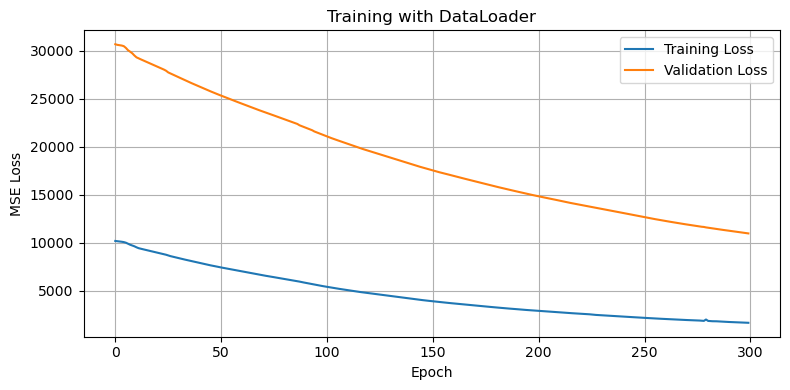

   True y  Predicted y
0      45    46.189999
1      65    70.089996
2      85    70.709999
3     105    70.769997
4     125    70.779999
5     145    70.779999
6     165    70.779999
7     185    70.779999


In [31]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from numpy import array, hstack

# ---------- 1. Dados ----------
in_seq1 = array([x for x in range(0,100,10)])
in_seq2 = array([x for x in range(5,105,10)])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
dataset = hstack((in_seq1, in_seq2, out_seq))

def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 3
X, y = split_sequences(dataset, n_steps)

# ---------- 2. Split + DataLoaders ----------
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

batch_size = 4
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# ---------- 3. Modelo ----------
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.linear(out[:, -1, :])

model = LSTMRegressor(input_dim=2, hidden_dim=16, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# ---------- 4. Treinamento ----------
train_losses = []
val_losses = []

for epoch in range(300):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(xb)
    train_losses.append(total_loss / len(train_loader.dataset))

    # Validação
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item() * len(xb)
        val_losses.append(val_loss / len(val_loader.dataset))

# ---------- 5. Curvas ----------
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training with DataLoader")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ---------- 6. Previsão final ----------
model.eval()
with torch.no_grad():
    all_tensor = torch.tensor(X, dtype=torch.float32)
    y_pred_all = model(all_tensor).numpy().flatten()

import pandas as pd
df = pd.DataFrame({
    'True y': y,
    'Predicted y': y_pred_all.round(2)
})
print(df)
